In [58]:
torch.cuda.empty_cache()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
torch.manual_seed(42)

# Hyperparameters
IMG_SIZE = 224
N_WAY = 5  # Number of classes per episode
K_SHOT = 5  # Number of support images per class
Q_QUERY = 15  # Number of query images per class
EPOCHS = 10
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

# Feature Extractor (ResNet-50)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification layer
        self.fc = nn.Linear(2048, 128)  # Reduce embedding dimension to 128
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)  # L2 normalization for cosine similarity

# Relation Network using Cosine Similarity
class RelationNet(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, support, query):
        return F.cosine_similarity(query.unsqueeze(1), support.unsqueeze(0), dim=2)  # Cosine similarity

# Few-Shot Learning Model
class RelationNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.relation_net = RelationNet()
    
    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)  # Shape: (N_WAY * K_SHOT, 128)
        query_embeddings = self.feature_extractor(query)  # Shape: (N_WAY * Q_QUERY, 128)
        relation_scores = self.relation_net(support_embeddings, query_embeddings)  # Shape: (N_WAY * Q_QUERY, N_WAY * K_SHOT)
        return relation_scores

# Training Function
def train_and_validate(dataset):
    model = RelationNetModel().cuda()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in range(EPOCHS):
        model.train()
        episode_loss, correct = 0, 0
        total_samples = 0

        for support, query, labels in dataset:
            support, query, labels = support.cuda(), query.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(support, query)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            episode_loss += loss.item()
            total_samples += labels.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        acc = correct / total_samples
        scheduler.step()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {episode_loss:.4f}, Accuracy: {acc:.4f}")
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_fewshot_model.pth")

# Run Training
dataset ="/home/mcw/Karthick/few_shot_learning/few_shot_dataset"  # Load your few-shot dataset
train_and_validate(dataset)


/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training on device: cuda
5-way 7-shot learning
Epoch 1/2 - Loss: 0.2143, Train Acc: 0.9188, Val Acc: 0.9180
Epoch 2/2 - Loss: 0.0176, Train Acc: 0.9957, Val Acc: 0.9900
Training complete! Best validation accuracy: 0.9900
Average 5-way 7-shot accuracy: 0.9901


Test Average 5-way 7-shot accuracy: 0.6585


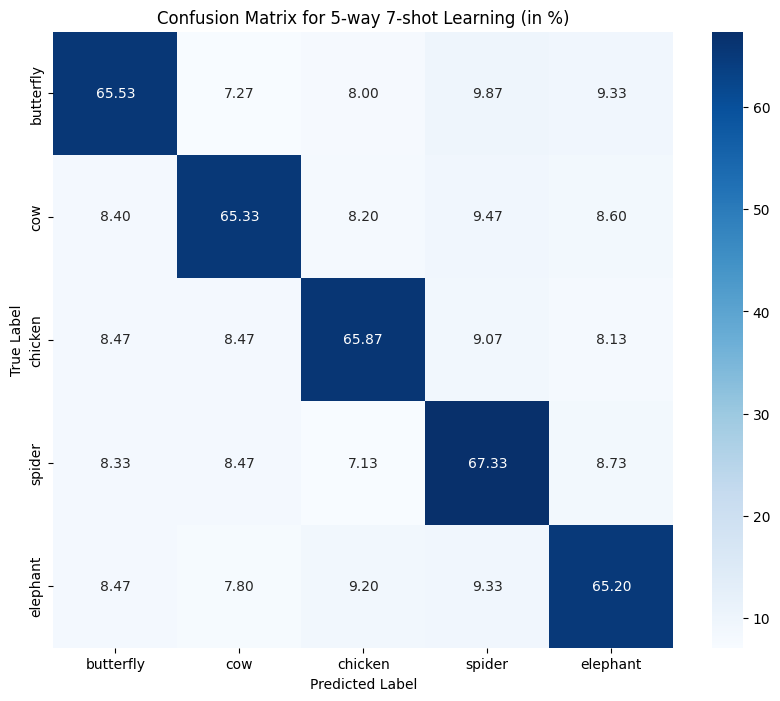

Confusion Matrix (in %):
[[65.53  7.27  8.    9.87  9.33]
 [ 8.4  65.33  8.2   9.47  8.6 ]
 [ 8.47  8.47 65.87  9.07  8.13]
 [ 8.33  8.47  7.13 67.33  8.73]
 [ 8.47  7.8   9.2   9.33 65.2 ]]


/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mcw/miniconda3/envs/ad-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Average 5-way 7-shot accuracy: 0.6536


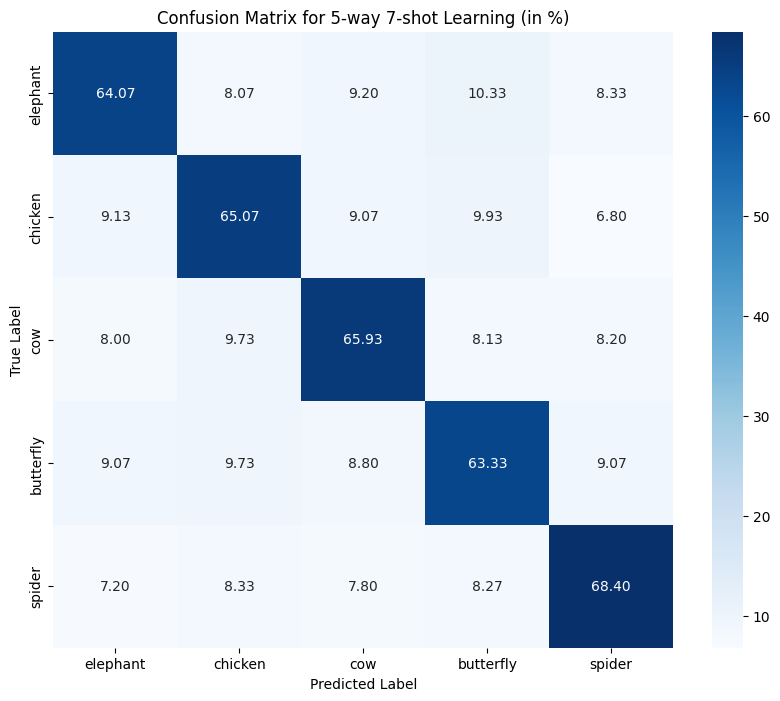

Confusion Matrix (in %):
[[64.07  8.07  9.2  10.33  8.33]
 [ 9.13 65.07  9.07  9.93  6.8 ]
 [ 8.    9.73 65.93  8.13  8.2 ]
 [ 9.07  9.73  8.8  63.33  9.07]
 [ 7.2   8.33  7.8   8.27 68.4 ]]


In [62]:
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from torchvision import transforms

def test_model(model=None, test_dir=None, num_episodes=100):
    if model is None:
        model = RelationNetModel().to(DEVICE)
        try:
            model.load_state_dict(torch.load("best_relationnet_model.pth"))
        except FileNotFoundError:
            print("No saved model found. Please train a model first.")
            return
        
    model.eval()
    
    class_names = os.listdir(test_dir)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
    
    accuracies = []
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for _ in range(num_episodes):
            selected_classes = random.sample(class_names, N_WAY)
            support_imgs, support_labels, query_imgs, query_labels = [], [], [], []
            
            for i, cls in enumerate(selected_classes):
                cls_dir = os.path.join(test_dir, cls)
                all_images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir)]
                random.shuffle(all_images)
                
                support_images = all_images[:K_SHOT]
                query_images = all_images[K_SHOT:K_SHOT + Q_QUERY]
                
                for img_path in support_images:
                    img = Image.open(img_path).convert('RGB')
                    img = transform(img)
                    support_imgs.append(img)
                    support_labels.append(i)
                
                for img_path in query_images:
                    img = Image.open(img_path).convert('RGB')
                    img = transform(img)
                    query_imgs.append(img)
                    query_labels.append(i)
            
            support_imgs = torch.stack(support_imgs).to(DEVICE)
            support_labels = torch.tensor(support_labels).to(DEVICE)
            query_imgs = torch.stack(query_imgs).to(DEVICE)
            query_labels = torch.tensor(query_labels).to(DEVICE)
            
            relation_scores = model(support_imgs, support_labels, query_imgs, N_WAY, K_SHOT)
            predictions = relation_scores.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(query_labels.cpu().numpy())
            
            accuracies.append((predictions == query_labels).float().mean().item())
    
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Test Average {N_WAY}-way {K_SHOT}-shot accuracy: {avg_accuracy:.4f}")
    
    conf_matrix = confusion_matrix(all_true_labels, all_predictions, labels=range(N_WAY))
    conf_matrix_percentage = conf_matrix.astype(np.float32) / conf_matrix.sum(axis=1, keepdims=True) * 100
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=selected_classes, yticklabels=selected_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {N_WAY}-way {K_SHOT}-shot Learning (in %)')
    plt.savefig('confusion_matrix_percentage.png')
    plt.show()
    
    print("Confusion Matrix (in %):")
    print(np.round(conf_matrix_percentage, 2))
    
    return avg_accuracy

if __name__ == "__main__":
    test_dir = "/home/mcw/Karthick/few_shot_learning/few_shot_dataset/test"
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_model(test_dir=test_dir)
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from torchvision import transforms

def test_model(model=None, test_dir=None, num_episodes=100):
    if model is None:
        model = RelationNetModel().to(DEVICE)
        try:
            model.load_state_dict(torch.load("best_relationnet_model.pth"))
        except FileNotFoundError:
            print("No saved model found. Please train a model first.")
            return
        
    model.eval()
    
    class_names = os.listdir(test_dir)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
    
    accuracies = []
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for _ in range(num_episodes):
            selected_classes = random.sample(class_names, N_WAY)
            support_imgs, support_labels, query_imgs, query_labels = [], [], [], []
            
            for i, cls in enumerate(selected_classes):
                cls_dir = os.path.join(test_dir, cls)
                all_images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir)]
                random.shuffle(all_images)
                
                support_images = all_images[:K_SHOT]
                query_images = all_images[K_SHOT:K_SHOT + Q_QUERY]
                
                for img_path in support_images:
                    img = Image.open(img_path).convert('RGB')
                    img = transform(img)
                    support_imgs.append(img)
                    support_labels.append(i)
                
                for img_path in query_images:
                    img = Image.open(img_path).convert('RGB')
                    img = transform(img)
                    query_imgs.append(img)
                    query_labels.append(i)
            
            support_imgs = torch.stack(support_imgs).to(DEVICE)
            support_labels = torch.tensor(support_labels).to(DEVICE)
            query_imgs = torch.stack(query_imgs).to(DEVICE)
            query_labels = torch.tensor(query_labels).to(DEVICE)
            
            relation_scores = model(support_imgs, support_labels, query_imgs, N_WAY, K_SHOT)
            predictions = relation_scores.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(query_labels.cpu().numpy())
            
            accuracies.append((predictions == query_labels).float().mean().item())
    
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Test Average {N_WAY}-way {K_SHOT}-shot accuracy: {avg_accuracy:.4f}")
    
    conf_matrix = confusion_matrix(all_true_labels, all_predictions, labels=range(N_WAY))
    conf_matrix_percentage = conf_matrix.astype(np.float32) / conf_matrix.sum(axis=1, keepdims=True) * 100
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=selected_classes, yticklabels=selected_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {N_WAY}-way {K_SHOT}-shot Learning (in %)')
    plt.savefig('confusion_matrix_percentage.png')
    plt.show()
    
    print("Confusion Matrix (in %):")
    print(np.round(conf_matrix_percentage, 2))
    
    return avg_accuracy

if __name__ == "__main__":
    test_dir = "/home/mcw/Karthick/few_shot_learning/few_shot_dataset/test"
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_model(test_dir=test_dir)
